## Machine Failure prediction with an Incremental Learning Algorithm

**Description:** Prediction of machine failure based on its working hours implementing SGDClassifier, considering data preprocessing using the following libraries:
- Numpy
- Pandas
- Matplotlib
- Sklearn

Dataset link: https://www.kaggle.com/c/machine-failure-prediction/data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix as cm
import seaborn as sns

(7905, 28)
Numerical Values verification
ID                              True
Temperature                     True
Humidity                        True
Operator                        True
Measure1                        True
Measure2                        True
Measure3                        True
Measure4                        True
Measure5                        True
Measure6                        True
Measure7                        True
Measure8                        True
Measure9                        True
Measure10                       True
Measure11                       True
Measure12                       True
Measure13                       True
Measure14                       True
Measure15                       True
Hours Since Previous Failure    True
Failure                         True
?Date.year                      True
?Date.month                     True
?Date.day-of-month              True
?Date.day-of-week               True
?Date.hour                      Tr

<BarContainer object of 2 artists>

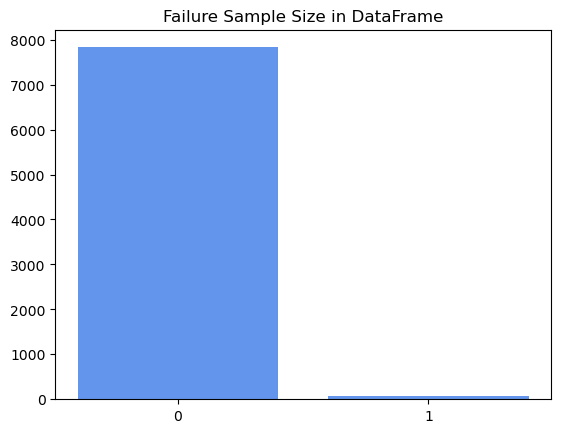

In [2]:
#File upload.
data = pd.read_csv("train.csv")
data

#As we can see, date and hour data are repeated, therefore we can erase Date column.
df = data.drop(columns=["Date"])

#DataFrame Size. 
print(df.shape)

#Review of data type. 
#print(df.info()) 

#By seeing the data, we can transform the Operator and failure columns.  
encoder = preprocessing.LabelEncoder()

df["Operator"] = encoder.fit_transform(df["Operator"])
df["Failure"] = encoder.fit_transform(df["Failure"])

df #Ensured changes have been made. 

#Review that all data is numeric type. 
print("Numerical Values verification")
print(df.apply(lambda x: pd.to_numeric(x, errors="coerce").notnull().all())) #We got a boolean value (True) which delimits all data is numeric 
print()

#Review that all data is not null.  
nulos = df.isnull().sum()
#print(nulos)

#We must see if how many samples show failures
fallas = df.groupby("Failure").size()
print(fallas) #We have more data with no failure than with failure. Which can become in an overfitting. 
plt.title("Failure Sample Size in DataFrame")
plt.bar(["0","1"],fallas[:], color="cornflowerblue")

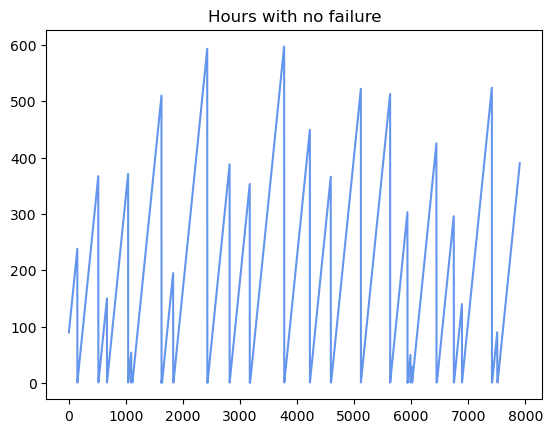

In [3]:
#Plot of range of hours with no failures. 
plt.title("Hours with no failure")
plt.plot(df["Hours Since Previous Failure"], color="cornflowerblue")

In [4]:
#Since our dataset is unbalanced, we will create different samples through boostrapping method. 
sample_size = len(df) #boostrapping size sample.
num_samples = 3 #Number of samples to generate with boostrappping. 

#Boostrapping Sample creation
boostrapped_samples = []

for _ in range(num_samples):
    sample = df.sample(n=sample_size, replace=True) #Replace = True, delimits that an array value can be selected multiple times. 
    #print(sample.shape)
    boostrapped_samples.append(sample)
    
#print(len(boostrapped_samples))

#X and Y delimitation for each sample. 
X_list = [boostrapped_samples[i].drop(columns=["Failure"]) for i in range(len(boostrapped_samples))]
Y_list = [boostrapped_samples[i]["Failure"] for i in range(len(boostrapped_samples))]

X_scaled_list = []
#Scalation and shuffling of samples.
for i in range(num_samples):
    X_list[i], Y_list[i] = shuffle(X_list[i], Y_list[i], random_state=0)
    scaler = preprocessing.StandardScaler().fit(X_list[i])
    X_scaled = scaler.transform(X_list[i])
    X_scaled_list.append(X_scaled)
    
#Division and generation of train and set tests.  
x_train_list = []
x_test_list = []
y_train_list = []
y_test_list = []

for i in range(num_samples):
    x_train, x_test, y_train, y_test = train_test_split(X_scaled_list[i],Y_list[i], test_size=0.2, train_size=0.8, random_state=42)
    x_train_list.append(x_train)
    x_test_list.append(x_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)

#Verification of each list size is correct. 
#print(x_train_list[0].shape)
#print(x_test_list[0].shape)
#print(y_train_list[0].shape)
#print(y_test_list[0].shape)

Model Accuracy: 99.49%
Error:  0.01
Model Accuracy: 99.68%
Error:  0.00
Model Accuracy: 99.68%
Error:  0.00


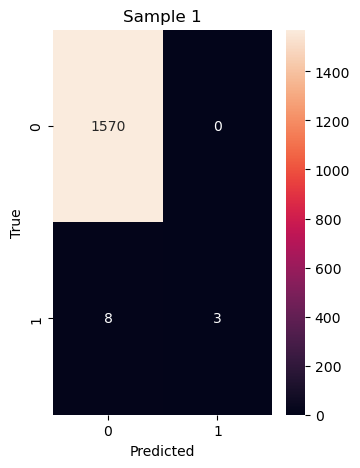

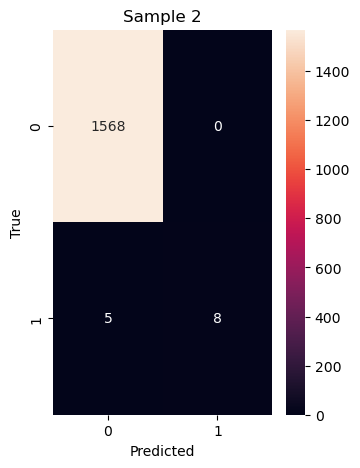

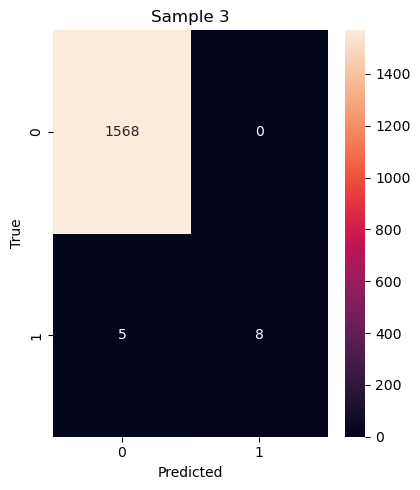

In [5]:
def training_method(x_train, y_train):
    classifier = SGDClassifier()  #Creation of our classifier
    model = classifier.partial_fit(x_train, y_train, classes = np.unique(y_train)) #Model training 
    return model

#Reminder: 
#    Train dataset names: x_train_list and y_train_list
#    Test dataset names: x_test_list y y_test_list.

for i in range(num_samples): 
    #1. Batch Training.
    best_model = training_method(x_train_list[i], y_train_list[i])
    
    #2. Model prediction
    y_pred = best_model.predict(x_test_list[i])
    
    #3. accuracy calculation
    score = accuracy_score (y_test_list[i], y_pred)  
    print(f"Model Accuracy: {round(score*100,2)}%") 
    
    #4. error calculation
    error = 1- score
    print("Error: ", format(error,".2f"))
    
    labels = np.unique(y_train)
    cf_matrix = cm(y_test_list[i], y_pred, labels=labels) 
    
    #Confusion matriz subplot
    plt.figure(figsize=(12,5))
    plt.subplot(1, num_samples, i+1)
    sns.heatmap (cf_matrix, annot=True, fmt="d", cbar=True) 
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Sample {i+1}")

plt.tight_layout() #Avoids that subplots underpose between each other. 
plt.show()